# Introduction

In this notebook, we used a multi-scenario multi-objective robust decision-making (MSMORDM) approach to perform a directed  search for optimal policies and subsequently evaluate for robustness. MSMORDM can be used to search for candidate policy alternatives using many objective evolutionary algorithms (MOEAs) for several reference scenarios (Bartholomew & Kwakkel, 2020). This notebook applies MS-MORDM to Problem Formulation 1, while notebook 4- Multi-scenario MORDM PF3.ipynb contains the analysis for Problem Formulation 3.

The worst case scenario identified in the open explanation has been used as a reference scenario to perform MORDM. 

## 0.0 Import libraries

In [1]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, CategoricalParameter, IntegerParameter,
                           SequentialEvaluator, MultiprocessingEvaluator, ema_logging,
                           Policy, Constant, Scenario, Constraint, save_results, load_results)
from ema_workbench.analysis import parcoords, prim
from ema_workbench.em_framework import optimization
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
ema_logging.log_to_stderr(ema_logging.INFO)

from problem_formulation import get_model_for_problem_formulation

import pandas as pd
import numpy as np
import time
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\jryap\Anaconda3\envs\primary\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)


# 1.0 Experimental Set-up
First, we select Problem Formulation 1, which yields 3 outcomes:
* Expected Annual Damage
* Total Investment Costs
* Expected Number of Deaths 

In [2]:
model, steps = get_model_for_problem_formulation(1)

Getting lists of model uncertainties, levers, and outcomes.

In [3]:
model_uncertainties = []
for i in model.uncertainties:
    model_uncertainties.append(i.name)

In [4]:
model_levers = []
for i in model.levers:
    model_levers.append(i.name)

In [5]:
model_outcomes = []
for i in model.outcomes:
    model_outcomes.append(i.name)

### Step 1: Searching for optimized levers given 1 reference scenario.
In this case, the reference scenario was selected from the open exploration process; it was the scenario that yielded the worst outcomes for in terms of Expected Number of Deaths.

In [6]:
reference = Scenario(**{'discount rate 0': 1.5, 'discount rate 1': 1.5, 'discount rate 2': 1.5,
                        'A.0_ID flood wave shape': 43.0, 'A.1_Bmax': 53.423569949295526,
                        'A.1_pfail': 0.20428240393608074, 'A.1_Brate': 10,
                        'A.2_Bmax': 267.3434506622656, 'A.2_pfail': 0.1804622034784221,
                        'A.2_Brate': 10, 'A.3_Bmax': 320.9123978280144,
                        'A.3_pfail': 0.028493206036833557, 'A.3_Brate': 1.5,
                        'A.4_Bmax': 283.8695071143246, 'A.4_pfail': 0.4432843146318262,
                        'A.4_Brate': 1.0, 'A.5_Bmax': 53.52141321453644, 
                        'A.5_pfail': 0.9576930156260828, 'A.5_Brate': 1.5})

In [7]:
convergence = [EpsilonProgress()]
epsilons = [0.5e5, 0.5e7, 0.001]

In [8]:
# starttime = time.time()

# with MultiprocessingEvaluator(model) as evaluator:
#     results = evaluator.optimize(nfe=12000, searchover='levers', reference=reference,
#                                  convergence = convergence, epsilons=epsilons)
    
# save_results(results, 'results/multi-scenario-mordm/pf1/msmordm_pf1_step1.tar.gz')
# print(time.time()-starttime)

### Step 2: Perform experiments given optimized levers from one reference scenario.

In [49]:
results = load_results('results/multi-scenario-mordm/pf1/msmordm_pf1_step1.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\jryap\Desktop\Final Results\results\multi-scenario-mordm\pf1\msmordm_pf1_step1.tar.gz


In [95]:
outcomes, convergence = results

Text(0.5, 1.0, 'Convergence: Reference Scenario')

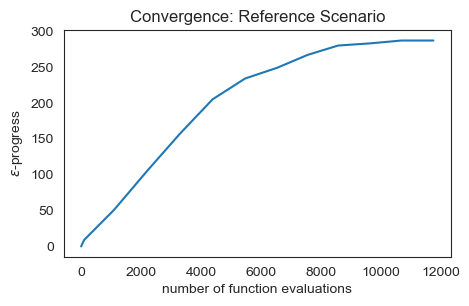

In [106]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(5,3), dpi=100)
convergence = pd.DataFrame(convergence)
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
ax.set_title("Convergence: Reference Scenario")

<Figure size 15000x5000 with 0 Axes>

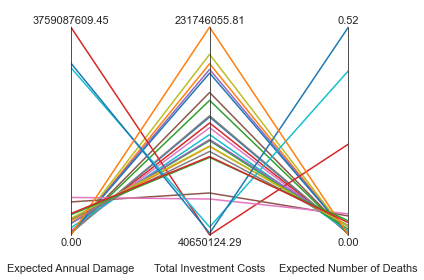

In [71]:
limits = parcoords.get_limits(outcomes[model_outcomes])
formatter = dict(zip(limits.columns, ['.2f']*(len(limits.columns))))
fig = plt.figure(figsize=(30,10), dpi=500)
paraxes = parcoords.ParallelAxes(limits, formatter=formatter,fontsize=11, rot=0)
for i in range(24):
    paraxes.plot(outcomes[outcomes.index==i][model_outcomes])

plt.show()

In [11]:
policy = outcomes[model_levers]

policies = []

for i,policy in policy.iterrows():
    policies.append(Policy(str(i),**policy.to_dict()))

In [12]:
# starttime = time.time()

# with MultiprocessingEvaluator(model) as evaluator:
#     results_step2 = evaluator.perform_experiments(scenarios=8000, policies=policies)

# save_results(results_step2, 'results/multi-scenario-mordm/pf1/msmordm_pf1_step2.tar.gz')
# print(time.time()-starttime)

### Step 3: Scenario discovery for selecting multiple scenarios of interest. 

In [13]:
results_step2 = load_results("results/multi-scenario-mordm/pf1/msmordm_pf1_step2.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\jryap\Desktop\Final Results\results\multi-scenario-mordm\pf1\msmordm_pf1_step2.tar.gz


In [14]:
experiments, outcomes = results_step2
outcomes_df = pd.DataFrame(outcomes)

#### Scenario Discovery using PRIM

In [15]:
x = experiments[model_uncertainties]
y = outcomes_df['Expected Annual Damage'] > np.percentile(outcomes_df['Expected Annual Damage'], 70)

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1 = prim_alg.find_box()

[MainProcess/INFO] 144000 points remaining, containing 43197 cases of interest
[MainProcess/INFO] mean: 0.9997381513485205, mass: 0.05304166666666667, coverage: 0.1767715350603051, density: 0.9997381513485205 restricted_dimensions: 6


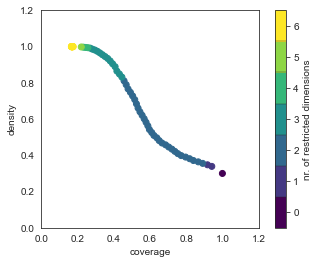

In [48]:
box1.show_tradeoff()
plt.show()

In [17]:
box1.inspect(33)

coverage    0.445309
density     0.831899
id                33
mass        0.160576
mean        0.831899
res_dim            3
Name: 33, dtype: object

                      box 33                                         
                         min       max                      qp values
A.5_pfail           0.000130  0.213692                    [-1.0, 0.0]
A.5_DikeIncrease 0  0.000000  0.500000                    [-1.0, 0.0]
A.4_pfail           0.040474  0.999861  [9.117776299425493e-17, -1.0]



In [18]:
box1.select(33)

In [19]:
selected_experiments = experiments.iloc[box1.yi]
selected_outcomes = {k:v[box1.yi] for k,v in outcomes_df.items()}

In [20]:
selected_experiments = selected_experiments.join(pd.DataFrame(selected_outcomes))

From the selected box of scenarios, we again filter the scenarios, and select only scenarios that yielded the worst performance for each of the three indicators.

In [23]:
del selected_experiments["policy"]
del selected_experiments["model"]

In [22]:
scenarios = []

# get scenarios for each worst-performing indicator
for i in range(len(outcomes_df.columns)):
    scenarios.append(selected_experiments.sort_values(by=outcomes_df.columns[i]).reset_index()["scenario"][0])

In [24]:
experiments_unique = selected_experiments.drop_duplicates(subset=["scenario"], keep="first")
experiments_unique = experiments_unique.loc[experiments_unique['scenario'].isin(scenarios) == True]
experiments_unique = experiments_unique.iloc[:, :-1]

In [25]:
reference = []

for i,uncertainty in experiments_unique.iterrows():
    reference.append(Scenario(str(i),**uncertainty.to_dict()))

Thus, we have three reference scenarios, under which we search for optimized levers.

In [ ]:
# outcomes = []

# starttime = time.time()

# for i in range(len(reference)):
#     with MultiprocessingEvaluator(model) as evaluator:
#         results_step3 = evaluator.optimize(searchover='levers', nfe=12000, epsilons=epsilons, 
#                                      convergence=convergence, reference=reference[i])
#     save_results(results_step3,
#                  "results/multi-scenario-mordm/pf1/msmordm_pf1_step3_ref{}.tar.gz".format(i))
#     outcomes.append(results_step3)

# print(time.time()-starttime)

### Step 4: 

In [73]:
results1 = load_results('results/multi-scenario-mordm/pf1/msmordm_pf1_step3_ref0.tar.gz')
results2 = load_results('results/multi-scenario-mordm/pf1/msmordm_pf1_step3_ref1.tar.gz')
results3 = load_results('results/multi-scenario-mordm/pf1/msmordm_pf1_step3_ref2.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\jryap\Desktop\Final Results\results\multi-scenario-mordm\pf1\msmordm_pf1_step3_ref0.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\jryap\Desktop\Final Results\results\multi-scenario-mordm\pf1\msmordm_pf1_step3_ref1.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\jryap\Desktop\Final Results\results\multi-scenario-mordm\pf1\msmordm_pf1_step3_ref2.tar.gz


In [74]:
outcomes1, convergence1 = results1
outcomes2, convergence2 = results2
outcomes3, convergence3 = results3
outcomes = [outcomes1, outcomes2, outcomes3]

First, we evaluate the convergence of the optimization runs.

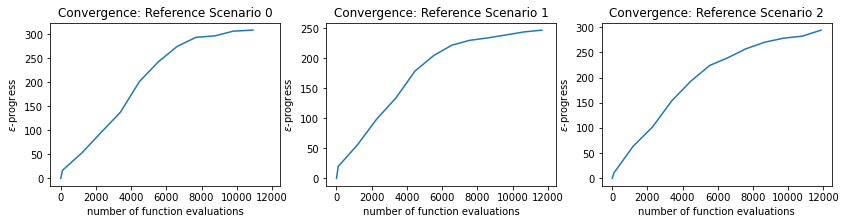

In [28]:
convergences = [pd.DataFrame(convergence1), pd.DataFrame(convergence2), pd.DataFrame(convergence3)]
fig, ax = plt.subplots(ncols=len(convergences), sharex=True, figsize=(14,3))

for i in range(len(convergences)):
    ax[i].plot(convergences[i].nfe, convergences[i].epsilon_progress)
    ax[i].set_ylabel('$\epsilon$-progress')
    ax[i].set_xlabel('number of function evaluations')
    ax[i].set_title("Convergence: Reference Scenario {}".format(i))

Then, we take a look at the tradeoffs between each policies with a parallel coordinates plot.

<Figure size 24000x8000 with 0 Axes>

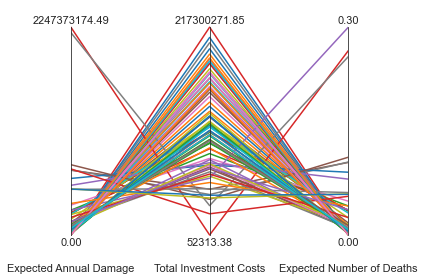

In [84]:
outcomes_concat = pd.concat(outcomes)
limits = parcoords.get_limits(outcomes_concat[model_outcomes])
formatter = dict(zip(limits.columns, ['.2f']*(len(limits.columns))))
fig = plt.figure(figsize=(30,10), dpi=800)
paraxes = parcoords.ParallelAxes(limits, formatter=formatter,fontsize=11, rot=0)
paraxes.plot(outcomes_concat[model_outcomes])
plt.show()

We sum up all policies for RfR. If this sum is equal to zero, this indicates that RfR is not implemented anywhere.

In [29]:
outcome_of_interest = "RfR"
for j in outcomes:
    outcomes_cols = []
    for i in j.columns:
        if outcome_of_interest in i:
            outcomes_cols.append(i)
    j["Total " + str(outcome_of_interest)] = j[outcomes_cols].sum(axis=1)

We filter and remove policies that do not include any implementation of RfR at any location. This leaves us with only 6 policies.

In [30]:
filtered_policies = pd.DataFrame()
for i in outcomes:
    filtered_policies = pd.concat([filtered_policies,
                                   i[i["Total RfR"] != 0]])

In [31]:
policy = filtered_policies[model_levers]
policies = []

for i,policy in policy.iterrows():
    policies.append(Policy(str(i),**policy.to_dict()))

In [32]:
len(policies)

6

In [33]:
# starttime = time.time()
# with MultiprocessingEvaluator(model) as evaluator:
#     results_step4 = evaluator.perform_experiments(scenarios=8000, policies=policies,
#                                                   uncertainty_sampling="lhs")

# save_results(results_step4, "results/multi-scenario-mordm/pf1/msmordm_pf1_step4.tar.gz")
# print(time.time()-starttime)

## 2.0 Analysis of Results
### 2.1 Overview of results

In [34]:
results_step4 = load_results("results/multi-scenario-mordm/pf1/msmordm_pf1_step4.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\jryap\Desktop\Final Results\results\multi-scenario-mordm\pf1\msmordm_pf1_step4.tar.gz


In [85]:
experiments, outcomes = results_step4

We use a parallel coordinates plot to generate an overview of the selected optimized policies.

In [154]:
policies_0 = [col for col in experiments[model_levers].columns if ' 0' in col]
policies_1 = [col for col in experiments[model_levers].columns if ' 1' in col]
policies_2 = [col for col in experiments[model_levers].columns if ' 2' in col]

experiments = experiments[model_levers].drop_duplicates()
time0 = experiments[policies_0]
time1 = experiments[policies_1]
time2 = experiments[policies_2]

times = [time0, time1, time2]

for i in range(len(times)):
    times[i]["Time Step"] = i
    times[i].columns = times[i].columns.str.replace(' {}'.format(i), '')
    times[i]["EWS Days to Threat"] = experiments["EWS_DaysToThreat"]
    times[i].index = [0, 1, 2, 3, 4, 5]
    
policies = pd.concat([time0, time1, time2])
limits = parcoords.get_limits(policies)
del limits["Time Step"]

C:\Users\jryap\Anaconda3\envs\primary\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jryap\Anaconda3\envs\primary\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 4500x6000 with 0 Axes>

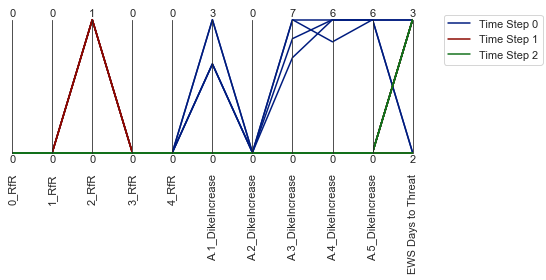

In [153]:
fig = plt.figure(figsize=(15,20), dpi=300)
formatter = dict(zip(limits.columns, ['.0f']*(len(limits.columns))))
paraxes = parcoords.ParallelAxes(limits, formatter=formatter,fontsize=11, rot=90)
paraxes.plot(time0, color=sns.color_palette("dark")[0], label='Time Step 0')
paraxes.plot(time1, color=sns.color_palette("dark")[3], label='Time Step 1')
paraxes.plot(time2, color=sns.color_palette("dark")[2], label='Time Step 2')
paraxes.legend()
plt.show()

In [44]:
experiments, outcomes = results_step4
experiments = experiments.join(pd.DataFrame(outcomes))
del experiments["policy"]
experiments["policy"] = 999
experiments.loc[:7999,"policy"] = 0
experiments.loc[8000:15999,"policy"] = 1
experiments.loc[16000:23999,"policy"] = 2
experiments.loc[24000:31999,"policy"] = 3
experiments.loc[32000:39999,"policy"] = 4
experiments.loc[40000:,"policy"] = 5

We use a parallel coordinates plot to generate an overview of the tradeoffs in outcomes over all policies (3 at a time) and scenarios.

<Figure size 6000x3000 with 0 Axes>

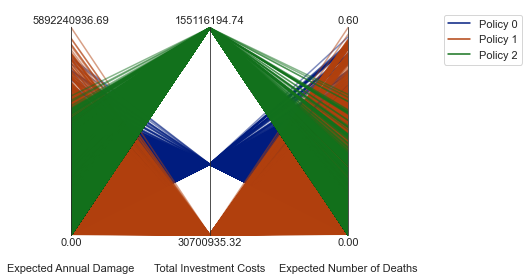

In [46]:
limits = parcoords.get_limits(experiments[model_outcomes])
formatter = dict(zip(limits.columns, ['.2f']*(len(limits.columns))))

fig = plt.figure(figsize=(20,10), dpi=300)
paraxes = parcoords.ParallelAxes(limits, formatter=formatter,fontsize=11, rot=0)
for i in range(3):
    paraxes.plot(experiments[experiments["policy"]==i][model_outcomes], color=sns.color_palette("dark")[i], alpha=0.5,
                 label="Policy {}".format(i))
paraxes.legend()
plt.show()

<Figure size 6000x3000 with 0 Axes>

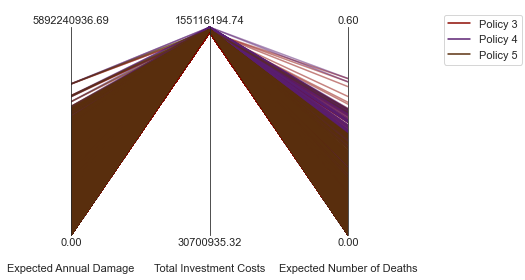

In [47]:
limits = parcoords.get_limits(experiments[model_outcomes])
formatter = dict(zip(limits.columns, ['.2f']*(len(limits.columns))))

fig = plt.figure(figsize=(20,10), dpi=300)
paraxes = parcoords.ParallelAxes(limits, formatter=formatter,fontsize=11, rot=0)
for i in range(3,6):
    paraxes.plot(experiments[experiments["policy"]==i][model_outcomes], color=sns.color_palette("dark")[i], alpha=0.5,
                 label="Policy {}".format(i))
paraxes.legend()
plt.show()

### 2.2 Robustness Metrics

We calculated the signal-to-noise ratio and the maximum regret for the policy outcomes in order to evaluate the robustness of the policies. 

In [109]:
experiments, outcomes = results_step4
del experiments["policy"]
experiments["policy"] = 999
experiments.loc[:7999,"policy"] = 0
experiments.loc[8000:15999,"policy"] = 1
experiments.loc[16000:23999,"policy"] = 2
experiments.loc[24000:31999,"policy"] = 3
experiments.loc[32000:39999,"policy"] = 4
experiments.loc[40000:,"policy"] = 5

In [90]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

def calculate_regret(data, best):
    return np.abs(best-data)

In [92]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

Parallel coordinates plot to evaluate the signal-to-noise ratio for each of the policies.

<Figure size 5000x10000 with 0 Axes>

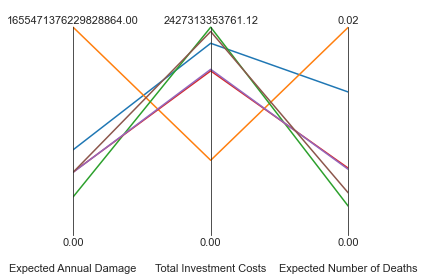

In [94]:
limits = parcoords.get_limits(scores)
limits.loc[0, outcomes.keys()] = 0

fig = plt.figure(figsize=(10,20), dpi=500)
paraxes = parcoords.ParallelAxes(limits, rot=0, fontsize=11)
paraxes.plot(scores)
plt.show()

In [134]:
experiments, outcomes = results_step4
del experiments["policy"]
experiments["policy"] = 999
experiments.loc[:7999,"policy"] = 0
experiments.loc[8000:15999,"policy"] = 1
experiments.loc[16000:23999,"policy"] = 2
experiments.loc[24000:31999,"policy"] = 3
experiments.loc[32000:39999,"policy"] = 4
experiments.loc[40000:,"policy"] = 5

In [135]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # Create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data.pivot(index='scenario', columns='policy')
    
    # Flatten the resulting hierarchical index resulting from pivoting
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data next we take the absolute value
    # basically we take the difference of the maximum acrossthe row and the actual values in the row
    
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    
max_regret = pd.DataFrame(max_regret)
max_regret['Policy'] = "Policy " + max_regret.reset_index()['policy'].astype('str').values
max_regret.set_index('Policy', inplace = True)

Generate a heatmap to show the maximum regret for each policy on each outcome.

In [136]:
import plotly
import plotly.graph_objs as go

heat = go.Heatmap(z=max_regret/max_regret.max(), x=max_regret.columns.tolist(), 
              y=max_regret.reset_index()['Policy'], xgap=10, ygap=10,
              colorscale = plotly.colors.sequential.Reds)

plot_data = [heat]

layout = go.Layout(title = 'Maximum Regret',
                   width=650, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   template = "plotly_white", )

fig=go.Figure(data=[heat], layout=layout) 
fig.show()
# fig.write_image(f"graphics/msmordm_pf1_step4_max_regret_heat.png", scale = 3)

<Figure size 6000x3000 with 0 Axes>

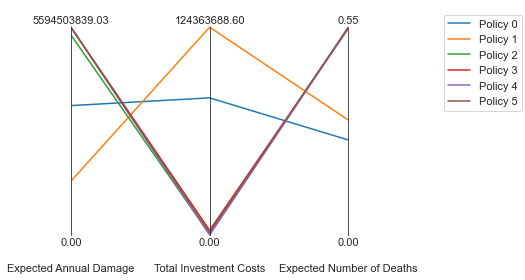

In [145]:
data = max_regret.copy()
fig = plt.figure(figsize=(20,10), dpi=300)
limits = parcoords.get_limits(data)
limits.loc[0, max_regret.columns] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=11, rot=0)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [146]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

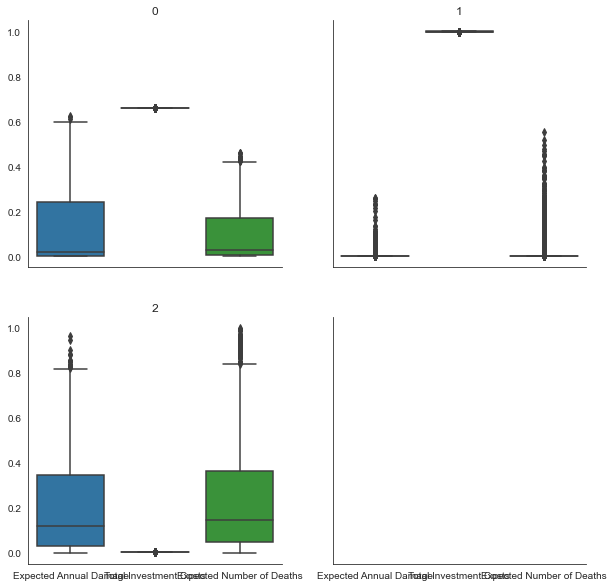

In [148]:
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],
        axes[1,0],]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    
#     ax.text(size = 8)
plt.show()
# plt.savefig(f"graphics/msmordm_pf1_step4_max_regret_dist.png", dpi=300)